# Hazard Dataset - Poisson Loss Function

In [1]:
import pandas as pd
import mxnet as mx
from mxnet import gluon, nd, autograd
mx.random.seed(1)
import numpy as np
from mxnet.gluon import nn

/Users/gireeg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetching Dataset

In [2]:
df = pd.read_csv('./train.csv',skiprows=1,header=None)

In [3]:
df_wo_nonnumeric = df.select_dtypes(include=np.number)

In [4]:
df_train_y = df_wo_nonnumeric[1]
np_train_y = df_train_y.values
df_train_x = df_wo_nonnumeric.drop(labels=1,axis =1)
np_train_x = df_train_x.values
X = nd.array(np_train_x)
Y  = nd.array(np_train_y)
X.shape, Y.shape

((50999, 17), (50999,))

In [5]:
num_examples = X.shape[0]
num_features = X.shape[1]
epochs = 10
num_outputs = 1
model_ctx = mx.cpu()
data_ctx = mx.cpu()

In [6]:
print("Number of training examples = ", num_examples)
print("Number of input features = ",num_features)
X_mean = nd.mean(X, axis=0)
X_SD = nd.array(np.std(X.asnumpy(),axis=0))
X_nm =  (X - X_mean) / X_SD

Number of training examples =  50999
Number of input features =  17


# DataLoader use:

In [7]:
batch_size = 256
# Genrate the training set usin ArrayDataSet
training_set = gluon.data.DataLoader(gluon.data.ArrayDataset(X_nm,Y), shuffle=True, batch_size = batch_size )

# Defining the loss function

In [8]:
def poisson_loss(#self, 
    F,             #data coming from caller
    pred,          #lambda - the rate of event occuring in a given interval
    target,        #the value of k (result  or the actual number of events happening)
    from_logits  = False,
    sample_weight= None, 
    compute_full = False,
    epsilon = 1e-12
    ):
       
        F=nd

        if from_logits:
            loss = F.exp(pred) - target * pred
        else:
            loss = pred - target * nd.log(pred+epsilon)

        return F.mean(loss)

# Defining the model

In [9]:
net = nn.Sequential()
# Add a sequence of layers.
net.add(
    nn.Dense(1,activation='relu'),
    nn.Dense(1)
)
    
net

Sequential(
  (0): Dense(None -> 1, Activation(relu))
  (1): Dense(None -> 1, linear)
)

In [10]:
# Calculating forward pass output of the model
def poissonloss_hidden(X):
    yhat1 = net(X);
    yhat = nd.exp(yhat1)
    return yhat

# Initializing model parameters - (Deferred initialization)

In [11]:
net.collect_params().initialize(mx.init.Normal(sigma=1), ctx=mx.cpu())

# Defining optimizer - SGD

In [12]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.06})

In [13]:
# Training loop
epochs = 50
loss_sequence = []
loss_seq = []
niter = 0
epochslist = []
num_batches = num_examples / batch_size
smoothing_constant = 0.5
moving_loss = 0

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(training_set):

        with autograd.record():
            output = poissonloss_hidden(data)
            loss =  poisson_loss(None,output, label, from_logits=False, compute_full=False)
        loss.backward()
        trainer.step(batch_size)
        niter +=1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss

        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        loss_seq.append(est_loss)
        cumulative_loss += nd.mean(loss).asscalar()
    if e % 5 ==0:    
        print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    loss_sequence.append(cumulative_loss/num_examples)
    epochslist.append(e)

Epoch 0, loss: 0.015770203660648453
Epoch 5, loss: -0.003554441270441347
Epoch 10, loss: -0.005147810104924157
Epoch 15, loss: -0.0058139088413346465
Epoch 20, loss: -0.00607601653202115
Epoch 25, loss: -0.0061504695926891334
Epoch 30, loss: -0.006174256254447231
Epoch 35, loss: -0.00617284678090294
Epoch 40, loss: -0.00618193989728123
Epoch 45, loss: -0.006187202374176263


# Plotting Loss function with epochs

Text(0,0.5,'loss')

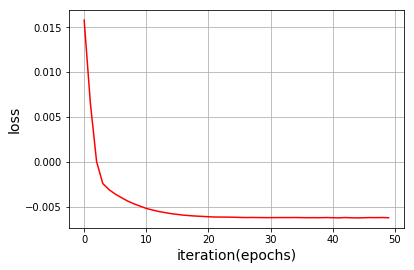

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(epochslist,loss_sequence,color='red')
plt.grid(True,which="both")
plt.xlabel('iteration(epochs)',fontsize=14)
plt.ylabel('loss',fontsize=14)

# Plotting Moving Averages of the Loss

Text(0,0.5,'est loss')

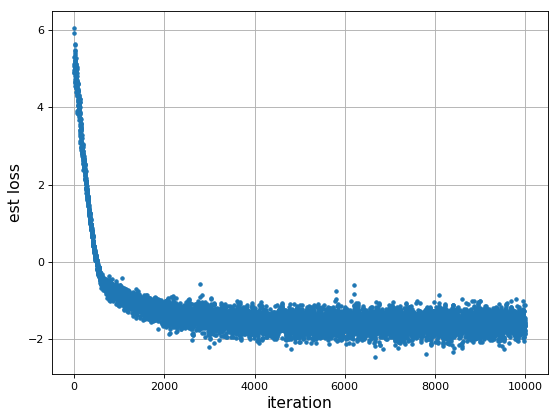

In [40]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)